<a href="https://colab.research.google.com/github/uadR1/nlphatespeech/blob/main/Hina/BERT_token_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/nlphatespeech
! git pull

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/nlphatespeech
Already up to date.


In [2]:
!ls

'All Data'   Aras   Daniel   Duygu   Hina   README.md


In [3]:
!ls

'All Data'   Aras   Daniel   Duygu   Hina   README.md


In [4]:
cd Hina/

/content/gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/nlphatespeech/Hina


In [ ]:
#! git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/uadR1/nlphatespeech
   621c56e..4724f17  main       -> origin/main
Updating 621c56e..4724f17
Fast-forward
 Hina/BERT_binary.ipynb | 348 +++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 348 insertions(+)
 create mode 100644 Hina/BERT_binary.ipynb


In [5]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 32.2 MB/s 
     |████████████████████████████████| 182 kB 67.7 MB/s 
     |████████████████████████████████| 7.6 MB 61.0 MB/s 


In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import os
import math

In [7]:
path = "/content/gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/nlphatespeech/Hina/df_all.csv"

df = pd.read_csv(path)
df.iloc[:,1] = df.iloc[:,1].astype(str)
# convert column text to string

df.head()
     

,Unnamed: 0,text,class
0,8,rt crooked hillary you didn't lose because yo...,explicit_hate
1,9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,34,are a bunch of religious bigots . i hope you e...,explicit_hate
3,45,hamas is the only one who lies and all those l...,explicit_hate
4,65,one of the questions never asked : if africans...,explicit_hate


In [8]:
df['class'].value_counts()

not_hate         36066
offensive        19190
implicit_hate     7100
explicit_hate     2519
Name: class, dtype: int64

In [9]:
df['hate']=df['class'].apply(lambda x: 0 if x=='not_hate' else 1)
df.head()

,Unnamed: 0,text,class,hate
0,8,rt crooked hillary you didn't lose because yo...,explicit_hate,1
1,9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate,1
2,34,are a bunch of religious bigots . i hope you e...,explicit_hate,1
3,45,hamas is the only one who lies and all those l...,explicit_hate,1
4,65,one of the questions never asked : if africans...,explicit_hate,1


In [10]:
df['hate'].value_counts()

0    36066
1    28809
Name: hate, dtype: int64

In [11]:
df['len_text'] = df['text'].str.len()
df.head()

,Unnamed: 0,text,class,hate,len_text
0,8,rt crooked hillary you didn't lose because yo...,explicit_hate,1,199
1,9,"rt estonian pm : "" i don't want blacks in es...",explicit_hate,1,101
2,34,are a bunch of religious bigots . i hope you e...,explicit_hate,1,135
3,45,hamas is the only one who lies and all those l...,explicit_hate,1,103
4,65,one of the questions never asked : if africans...,explicit_hate,1,143


In [12]:
df.describe()

,Unnamed: 0,hate,len_text
count,64875.000000,64875.000000,64875.000000
mean,10958.991584,0.444069,96.306975
std,6492.230353,0.496866,62.724153
min,0.000000,0.000000,1.000000
25%,5406.000000,0.000000,55.000000
50%,10812.000000,0.000000,86.000000
75%,16218.000000,1.000000,122.000000
max,24782.000000,1.000000,1492.000000


In [19]:
df[df['len_text']>122]

,Unnamed: 0,text,class,hate,len_text
0,8,rt crooked hillary you didn't lose because yo...,explicit_hate,1,199
2,34,are a bunch of religious bigots . i hope you e...,explicit_hate,1,135
4,65,one of the questions never asked : if africans...,explicit_hate,1,143
6,75,the uncultured and uncivilized men from cental...,explicit_hate,1,133
8,98,""" by the quran we will kill you all you fa...",explicit_hate,1,126
...,...,...,...,...,...
64856,18593,Of course. But what I was trying to say is tha...,not_hate,0,146
64863,18600,Don't be surprised when they take the vote to ...,not_hate,0,295
64868,18605,Have you heard the latest bit where now if the...,not_hate,0,183
64869,18606,So then describe the concept by which that sys...,not_hate,0,359


In [22]:
df[df['len_text']>200]

,Unnamed: 0,text,class,hate,len_text
44,977,civic nationalism is three cucks arguing abou...,explicit_hate,1,229
58,1303,dumbocrats help me out here . crooked hillary ...,explicit_hate,1,280
118,2617,the league doesn't believe in cucking and disa...,explicit_hate,1,253
374,8262,what you deserve for being useless white goy i...,explicit_hate,1,231
539,10804,rather than trying to build our own institutio...,explicit_hate,1,277
...,...,...,...,...,...
64823,18560,Brian has a right to prove his innocence every...,not_hate,0,350
64825,18562,20 Republicans working with Democrats right no...,not_hate,0,350
64855,18592,that's not my point... my point is that the ar...,not_hate,0,224
64863,18600,Don't be surprised when they take the vote to ...,not_hate,0,295


In [24]:
df[df['len_text']>300]

,Unnamed: 0,text,class,hate,len_text
1041,20812,It's time to purge the entire landmass of the ...,explicit_hate,1,331
1052,20860,I'd bet a bag full of the finest jew hair that...,explicit_hate,1,363
1053,20861,Some faggot-loving newspaper wants folks to st...,explicit_hate,1,353
1082,20930,"Every now and then, as sure as clockwork, a mi...",explicit_hate,1,303
2839,6595,"rt bernie isn't "" bad "" "" but even dsa left...",implicit_hate,1,309
...,...,...,...,...,...
64740,18477,It's zero sum game between European powers i.e...,not_hate,0,315
64804,18541,"Wenn ein Politiker vom ""echten innerem Ringen“...",not_hate,0,333
64823,18560,Brian has a right to prove his innocence every...,not_hate,0,350
64825,18562,20 Republicans working with Democrats right no...,not_hate,0,350


In [23]:
df[df['len_text']>400]

,Unnamed: 0,text,class,hate,len_text
7664,20950,"A gay guy, A black guy, and A Jew get hit by a...",implicit_hate,1,762
7690,20976,A black guy finds a genie in a bottle Any thre...,implicit_hate,1,432
7963,21249,pink shutters a man walked into a whore house ...,implicit_hate,1,801
8021,21307,shopkeeper runs the numbers . fifteen skinhead...,implicit_hate,1,406
8063,21349,"Old woman:: ""Schools shouldn't offer free lunc...",implicit_hate,1,502
...,...,...,...,...,...
64241,17978,I have listened to career investigators and pr...,not_hate,0,575
64411,18148,IMPORTANT Michael Caputo Explains How Clinton-...,not_hate,0,422
64482,18219,"Howdy, #GabFam! Long time, no post. Just a qui...",not_hate,0,403
64516,18253,"Dear #GabFam, I've never asked you for money b...",not_hate,0,401


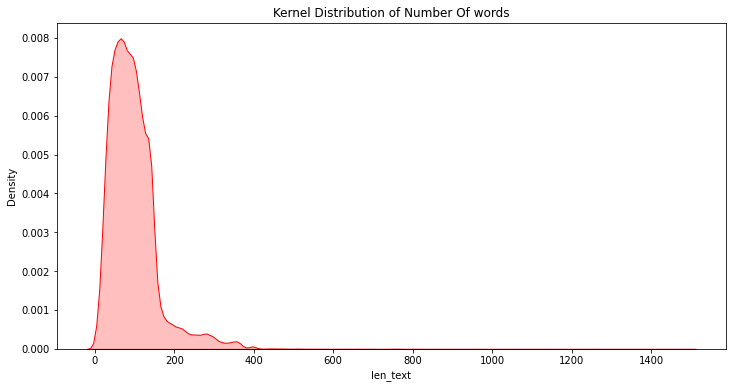

In [21]:
# Check distribtion of number of words 
import seaborn as sns
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['len_text'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')

# Separate text and labels

In [25]:
text = df.text.values
labels = df.hate.values

# PreProcessing for BERT

In [26]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Verify Pre-processed tokenizer without BERT Preprocessing

In [27]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ @        │        1030 │
├──────────┼─────────────┤
│ kay      │       10905 │
├──────────┼─────────────┤
│ ##lie    │        8751 │
├──────────┼─────────────┤
│ ##far    │       14971 │
├──────────┼─────────────┤
│ ##mer    │        5017 │
├──────────┼─────────────┤
│ @        │        1030 │
├──────────┼─────────────┤
│ bb       │       22861 │
├──────────┼─────────────┤
│ ##lu     │        7630 │
├──────────┼─────────────┤
│ ##ed     │        2098 │
├──────────┼─────────────┤
│ ##rea    │       16416 │
├──────────┼─────────────┤
│ ##mm     │        7382 │
├──────────┼─────────────┤
│ no       │        2053 │
├──────────┼─────────────┤
│ but      │        2021 │
├──────────┼─────────────┤
│ if       │        2065 │
├──────────┼─────────────┤
│ you      │        2017 │
├──────────┼─────────────┤
│ dare     │        8108 │
├──────────┼─────────────┤
│ i        │        1045 │
├──────────┼─────────────┤
│

# Reference 
https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

BERT requires the following preprocessing steps:

Add special tokens:
- [CLS]: at the beginning of each sentence (ID 101)
- [SEP]: at the end of each sentence (ID 102)
Make sentences of the same length:
- This is achieved by padding, i.e. adding values of convenience to shorter sequences to match the desired length. Longer sequences are truncated.
- The padding ([PAD]) tokens have ID 0.
- The maximum sequence length allowed is of 512 tokens¹.
Create an attention mask:
- List of 0/1 indicating whether the model should consider the tokens or not when learning their contextual representation. We expect [PAD] tokens to have value 0.

## Tokenisation by BERT
tokenizer.encode_plus method is used. When called, it returns a transformers.tokenization.tokenization-utils_base.BatchEncoding object with the following fields:

input_ids: list of token IDs.
token_type_ids: list of token type IDs.
attention_mask: list of 0/1 indicating which tokens should be considered by the model (return_attention_mask = True).
max_length = 32, longer sentences will be truncated, while shorter sentences will be populated with [PAD] tokens (id: 0) until they reach the desired length.

In [28]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        #max_length = 32,
                        max_length = 200, # There are 3749/16067 cases greater than 200 , sort we truncate them
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Tokenization Check with BERT Preprocessing

In [29]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ rt       │       19387 │                1 │
├──────────┼─────────────┼──────────────────┤
│ @        │        1030 │                1 │
├──────────┼─────────────┼──────────────────┤
│ d        │        1040 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##fk     │       24316 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##in     │        2378 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##lo     │        4135 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##pes    │       10374 │                1 │
├──────────┼─────────────┼──────────────────┤
│ :        │        1024 │                1 │
├──────────┼─────────────┼──────────────────┤
│ lying    │        4688 │        

***Note***: BERT is a model with absolute position embeddings, so it is usually advised to pad the inputs on the right (end of the sequence) rather than the left (beginning of the sequence). In our case, tokenizer.encode_plus takes care of the needed preprocessing.

# Split train and test

In [30]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels,
    random_state=42)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

## Hyperpaarmeter Tuning

he optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4

### fine tuning BERT
Define custom metrics for evaluation using TP,FP,FN,TN

In [34]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  b_F1_score = 2*((b_precision * b_recall)/(b_precision + b_recall)) if (b_precision + b_recall) > 0 else 'nan'
  #MCC = (TP*TN – FP*FN) / √(TP+FP)(TP+FN)(TN+FP)(TN+FN)
  b_mcc_score = ((tp*tn)-(fp*fn))/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))) if (tp+fp+tn+fn) >0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity, b_F1_score , b_mcc_score, tp, tn, fp,fn

# BERT Classifier Model

In [33]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Training

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_F1_score = []

    val_mcc_score =[]
    val_tp =[]
    val_tn=[]
    val_fp=[]
    val_fn=[]

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity,b_F1_score ,b_mcc_score, tp,tn,fp,fn = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
        # Update f1_score only when (precision + recall) !=0; ignore nan
        if b_F1_score != 'nan': val_F1_score.append(b_F1_score)

        # Update mcc_score only when (tp+tn+fn+fp) !=0; ignore nan
        if b_mcc_score != 'nan': val_mcc_score.append(b_mcc_score)
        val_tp.append(tp)
        val_tp.append(tn)
        val_tp.append(fp)
        val_tp.append(fn)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1_score: {:.4f}'.format(sum(val_F1_score)/len(val_F1_score)) if len(val_F1_score)>0 else '\t - Validation F1_score: NaN')

    print('\t - Validation mcc_score: {:.4f}'.format(sum(val_mcc_score)/len(val_mcc_score)) if len(val_mcc_score)>0 else '\t - Validation mcc_score: NaN')
    print('\t - Validation TP: {:.4f}'.format(sum(val_tp)/len(val_tp)))
    print('\t - Validation TN: {:.4f}'.format(sum(val_tn)/len(val_tn)))
    print('\t - Validation FP: {:.4f}'.format(sum(val_fp)/len(val_fp)))
    print('\t - Validation FN: {:.4f}'.format(sum(val_fn)/len(val_fn)))

Epoch:   0%|          | 0/2 [31:08<?, ?it/s]


	 - Train loss: 0.2702
	 - Validation Accuracy: 0.8926
	 - Validation Precision: 0.8605
	 - Validation Recall: 0.9056
	 - Validation Specificity: 0.8814

	 - Validation F1_score: 0.8746
	 - Validation mcc_score: 0.7836
	 - Validation TP: 3.9997


ZeroDivisionError: ignored

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_F1_score = []

    val_mcc_score =[]
    val_tp =[]
    val_tn=[]
    val_fp=[]
    val_fn=[]

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity,b_F1_score ,b_mcc_score, tp,tn,fp,fn = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
        # Update f1_score only when (precision + recall) !=0; ignore nan
        if b_F1_score != 'nan': val_F1_score.append(b_F1_score)

        # Update mcc_score only when (tp+tn+fn+fp) !=0; ignore nan
        if b_mcc_score != 'nan': val_mcc_score.append(b_mcc_score)
        val_tp.append(tp)
        val_tp.append(tn)
        val_tp.append(fp)
        val_tp.append(fn)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1_score: {:.4f}'.format(sum(val_F1_score)/len(val_F1_score)) if len(val_F1_score)>0 else '\t - Validation F1_score: NaN')

    print('\t - Validation mcc_score: {:.4f}'.format(sum(val_mcc_score)/len(val_mcc_score)) if len(val_mcc_score)>0 else '\t - Validation mcc_score: NaN')
    print('\t - Validation TP: {:.4f}'.format(sum(val_tp)/len(val_tp)) if len(val_tp)>0 else '\t Validation tp: NaN' )
    print('\t - Validation TN: {:.4f}'.format(sum(val_tn)/len(val_tn)) if len(val_tn)>0 else '\t Validation tn: NaN' )
    print('\t - Validation FP: {:.4f}'.format(sum(val_fp)/len(val_fp)) if len(val_fp)>0 else '\t Validation fp: NaN' )
    print('\t - Validation FN: {:.4f}'.format(sum(val_fn)/len(val_fn)) if len(val_fn)>0 else '\t Validation fn: NaN' )

Epoch:  50%|█████     | 1/2 [31:05<31:05, 1865.46s/it]


	 - Train loss: 0.1961
	 - Validation Accuracy: 0.8945
	 - Validation Precision: 0.8649
	 - Validation Recall: 0.9089
	 - Validation Specificity: 0.8820

	 - Validation F1_score: 0.8780
	 - Validation mcc_score: 0.7892
	 - Validation TP: 3.9997
	 Validation tn: NaN
	 Validation fp: NaN
	 Validation fn: NaN


Epoch: 100%|██████████| 2/2 [1:02:10<00:00, 1865.04s/it]


	 - Train loss: 0.1347
	 - Validation Accuracy: 0.8990
	 - Validation Precision: 0.9208
	 - Validation Recall: 0.8513
	 - Validation Specificity: 0.9369

	 - Validation F1_score: 0.8755
	 - Validation mcc_score: 0.7966
	 - Validation TP: 3.9997
	 Validation tn: NaN
	 Validation fp: NaN
	 Validation fn: NaN


## Save the model

In [37]:
model.save_pretrained("/content/gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/saved_model")

# Prediction

In [38]:
#new_sentence = 'No matter how much you try those fuckers cannot change. I am just tried of all the shit I take everyday and all for no good. '
new_sentence= "you are distraught by the fact the video dispels myths / falsehoods of ' innocent ' black man assaulted by ' evil ' whites ."
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Hate' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not_Hate'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  you are distraught by the fact the video dispels myths / falsehoods of ' innocent ' black man assaulted by ' evil ' whites .
Predicted Class:  Not_Hate


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Load the saved model and test 

In [39]:
from transformers import BertForSequenceClassification

model_loaded = BertForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/saved_model/")
model_loaded=model_loaded.to(device)

## Predictions using loaded model

In [40]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'
#new_sentence_load_model= 'I dont hate you but i cannot tolerate you anymore' Not Hate 
#new_sentence_load_model = 'I dont hate you but i cannot tolerate you anymore. Please get out of my sight!' #Classified as Not Hate
#new_sentence_load_model = 'Oh dear! Seriously???!!!. Do you really think you want a piece of me!'  #Not_hate
new_sentence_load_model="every white area / country is the most modern  civilised & clean .. it's no wonder they want to flock like rats .. their countries will be empty one day while ours are over run with them .. its wrong ! people didn't fight & die to protect our countries to be over run today ."

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence_load_model, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model_loaded(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Hate' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not_Hate'

print('Input Sentence: ', new_sentence_load_model)
print('Predicted Class: ', prediction)

Input Sentence:  every white area / country is the most modern  civilised & clean .. it's no wonder they want to flock like rats .. their countries will be empty one day while ours are over run with them .. its wrong ! people didn't fight & die to protect our countries to be over run today .
Predicted Class:  Hate


In [ ]:
!git commit -m BERT_BINARY


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@93f03b8086c3.(none)')


In [ ]:
!git config --global user.email 'tanvir.hina7@gmail.com'
!git config --global user.name 'hinatanvir'

In [ ]:
from getpass import getpass
password = getpass('Password:')

Password:··········


In [ ]:
!ls

'All Data'   Aras   Daniel   Duygu   Hina   README.md


In [ ]:
%cd Hina

/content/gdrive/MyDrive/Colab Notebooks/Hate_Speech_NLP/nlphatespeech/Hina


In [ ]:
!git add BERT_binary.ipynb
!git commit -m 'BERT_BIN'

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
